In [5]:
%matplotlib inline
import os
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt

inp_path = '../COL780-A1-Data/illumination/input'
out_path = '../COL780-A1-Data/illumination/preds'
category = 'i'
eval_frames = '../COL780-A1-Data/illumination/eval_frames.txt'

args = argparse.Namespace(
    inp_path=inp_path,
    out_path=out_path,
    category=category,
    eval_frames=eval_frames
)

In [6]:
def get_input_frames(args, bnw=False):
    '''
    Get list of (image name, image as a numpy array)
    Params
    ------
    bnw : Bool
        convert to black and white
    '''
    filenames = os.listdir(args.inp_path)
    inp_frames = []
    for i, filename in enumerate(filenames):
        img = cv2.imread(os.path.join(args.inp_path, filename))
        if bnw:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        inp_frames.append((filename, img))
    inp_frames = sorted(inp_frames, key=lambda x : x[0])
    return inp_frames

In [7]:
inp_frames = get_input_frames(args, False)

In [8]:
inp_frames_gray = get_input_frames(args, True)

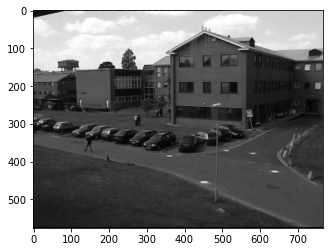

In [9]:
img = inp_frames_gray[200][1]
plt.imshow(img, cmap='gray')
plt.show()

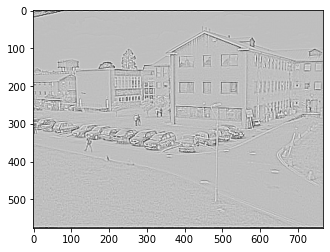

In [10]:
smooth = cv2.GaussianBlur(img,(9,9),0)
new_img = cv2.divide(img,smooth,scale=192)
plt.imshow(new_img, cmap='gray')
plt.show()

In [5]:
def get_eval_indices(args):
    '''
    Get start and end index as given in eval_frames
    '''
    s, e = 0, 0
    with open(args.eval_frames, 'r') as f:
        s, e = map(int, f.readline().split())
    return s, e

def write_output_frames(args, out_frames):
    '''
    Write output frames to file
    '''
    if not os.path.isdir(args.out_path):
        os.mkdir(args.out_path)

    for filename, img in out_frames:
        filename = 'gt' + filename[2:-3] + 'png'
        cv2.imwrite(os.path.join(args.out_path, filename), img)

In [41]:
import vibe
masks = []

def post_process(masks, kernel_dim=5):
    kernel = np.ones((kernel_dim,kernel_dim),np.uint8)
    new_masks = []
    for filename, mask in masks:
        mask = mask.astype('uint8')
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        new_masks.append((filename, mask))
    return new_masks

def gmm(inp_frames, s, e, detectShadows=True):
    fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows = detectShadows)

    for i in range(s-1):
        fgbg.apply(inp_frames[i][1])
    out_frames = []
    for i in range(s-1,e):
        mask = fgbg.apply(inp_frames[i][1])
        mask = (mask > 200) * 255
        mask = mask.astype('uint8')
        out_frames.append((inp_frames[i][0], mask))
        
    return out_frames

def median_filter(inp_frames, s, e, medianOverAll=True , k=40):
    # Get median at each pixel
    nrows, ncols = inp_frames[0][1].shape
    num_frames = len(inp_frames)
    if not medianOverAll:
        num_frames = s-1
    all_inp = np.zeros((num_frames, nrows, ncols))

    for i in range(num_frames):
        all_inp[i,:,:] = inp_frames[i][1]
    median = np.median(all_inp, axis=0)
    median = median.astype(int)
    
    out_frames = []
    # Declare foreground if I - mean <= k
    for i in range(s-1, e):
        filename, img = inp_frames[i]
        mask = (np.abs(img - median) >= k) * 255
        out_frames.append((filename, mask))

    return out_frames

def equalizeHist(inp_frames):
    new_frames = []
    for filename, img in inp_frames:
        new_frames.append((filename, cv2.equalizeHist(img)))
    return new_frames

def normalise_pixel_vals(inp_frames):
    new_frames = []
    for filename, img in inp_frames:
        normalizedImg = np.zeros(img.shape)
        normalizedImg = cv2.normalize(img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
        new_frames.append((filename, normalizedImg))
    return new_frames

def blur_image(inp_frames, kernel_dim=5):
    new_frames = []
    for filename, img in inp_frames:
        new_frames.append((filename, cv2.GaussianBlur(img,(kernel_dim,kernel_dim),0)))
    return new_frames

def to_grayscale(inp_frames):
    new_frames = []
    for filename, img in inp_frames:
        new_frames.append((filename, cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)))
    return new_frames

def apply_clahe(inp_frames):
    new_frames = []
    for filename, img in inp_frames:
        lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        l, a, b = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
        cl = clahe.apply(l)

        limg = cv2.merge((cl,a,b))

        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        new_frames.append((filename,final))
    return new_frames

def baseline_bgs(args):
    s, e = get_eval_indices(args)
    global masks
    masks = median_filter(inp_frames, s, e, True)
    masks = post_process(masks)

def illumination_bgs(args):
    s, e = get_eval_indices(args)
    global masks
    
    masks = gmm(inp_frames, s, e)
    masks = post_process(masks, kernel_dim=9)
    
    # Only for testing, not in final submission
    resized_masks = []
    for filename, mask in masks:
        mask = cv2.resize(mask, (320,240))
        resized_masks.append((filename, mask))
    masks = resized_masks

def jitter_bgs(args):
    
    pass


def dynamic_bgs(args):
    s, e = get_eval_indices(args)
    global masks
    print(s)
    masks = median_filter(inp_frames_gray, s, e, True, k=60)
    masks = post_process(masks)
    pass


def ptz_bgs(args):
    #TODO: (Optional) complete this function
    pass

In [42]:
FUNCTION_MAPPER = {
        "b": baseline_bgs,
        "i": illumination_bgs,
        "j": jitter_bgs,
        "m": dynamic_bgs,
        "p": ptz_bgs
    }

FUNCTION_MAPPER[args.category](args)

800


In [43]:
write_output_frames(args, masks)

In [44]:
def show_image_rgb(img):
    plt.imshow(img[:,:,::-1])
    plt.show()
    
def show_image_gray(img):
    plt.imshow(img, cmap='gray')
    plt.show()
    
def show_image(img):
    if img.ndim == 3:
        show_image_rgb(img)
    else:
        show_image_gray(img)

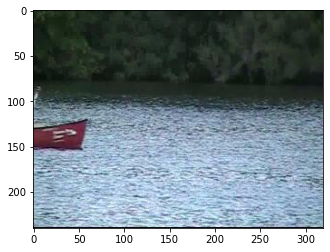

In [45]:
show_image(inp_frames[862][1])

390


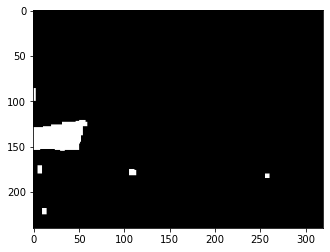

In [47]:
print(len(masks))
filename, mask = masks[62]
show_image(mask)

In [ ]:
write_output_frames(args, out_frames)